「クラス分類モデルの訓練方法」
===============================================================
【原題】TRAINING A CLASSIFIER

【原著】[Soumith Chintala](http://soumith.ch/)

【元URL】https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　徳原 光

【日付】2020年11月5日

【チュートリアル概要】

データセット「CIFAR-10」の画像分類を実装しながら、PyTorchを用いてニューラルネットワークを構築し、モデルを訓練する方法を解説します。

---



クラス分類の学習方法
=====================
本チュートリアルは「Deep Learning with PyTorch: A 60 Minute Blitz」（合計4本）の最後となります。

これまでに、ニューラルネットワークを定義し、損失を計算し、ネットワークの重みを更新する方法を解説してきました。

今、皆様は次のような疑問を持っているかもしれません。

**「データはどうするのだろうか？」**


一般的に、画像、テキスト、音声、動画などのデータを扱う場合は、numpy配列にデータを読み込むことや、標準的なPythonパッケージを利用することができます。

そして、numpy配列から``torch.*Tensor``を用いて、テンソルに変換することが可能です。

-  画像の場合は、Pillow、OpenCVなどのパッケージが便利です
-  音声に対しては scipy や librosa などのパッケージがあります
-  テキストの場合は、そのままのPythonまたはCythonによる読み込み、もしくはNLTKやSpaCyが便利です


PyTorchでは、特に画像データのために、ImagenetやCIFAR10、MNISTといったデータセットの読み込み機能と画像データの変換機能を持つ、``torchvision``と呼ばれるパッケージを開発しました。

パッケージには、``torchvision.datasets`` や``torch.utils.data.DataLoader``が含まれています。

これらはユーザーに多くの便利な機能を提供します。また、定型的なコードの記述を省略することもできます。



本チュートリアルでは、「CIFAR10データセット」を使用します。

このデータセットには「飛行機」、「自動車」、「鳥」、「猫」、「鹿」、「犬」、「カエル」、「馬」、「船」、「トラック」のクラスが含まれています。

また、CIFAR-10の画像はサイズが3×32×32、すなわち3つの色チャネルを持つ32×32ピクセルの画像になります。

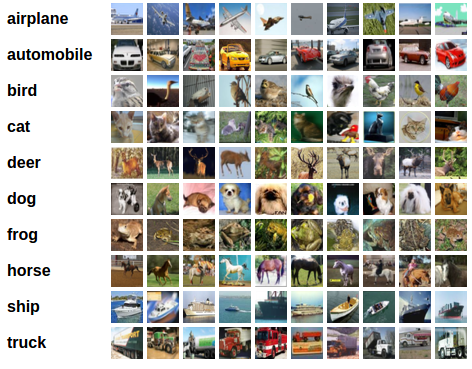

   cifar10






**画像分類器の訓練**


以下の手順に従って実施します：

1. ``torchvision``を用いた、CIFAR10の訓練データとテストデータの読み込みと正規化
2. 畳み込みニューラルネットワークの定義
3. 損失関数の定義
4. 訓練データを用いたネットワークの訓練
5. テストデータでネットワークをテスト



[1] CIFAR10の読み込みと正規化
========

``torchvision``を使えば、CIFAR10の読み込みを非常に簡単に行うことができます。

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

``torchvision``データセットの出力は、値が0から1の範囲のPILImageイメージになります。

これを値が-1から1の範囲に付近に正規化されたTensor（テンソル）に変換します。

<br>

（日本語訳注：PILImageイメージは前述の画像処理ライブラリPillowで扱われる画像データのことを指します。）

注意：

Windows環境で実行していて、**BrokenPipeError**が発生した場合は、``torch.utils.data.DataLoader()``の``num_worker``を0に設定してください

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


それでは訓練画像を楽しく眺めてみましょう。




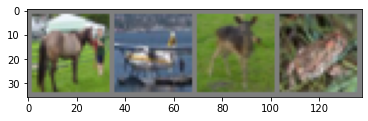

horse plane  deer  frog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 画像の表示関数


def imshow(img):
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 適当な訓練セットの画像を取得
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

[2] 畳み込みニューラルネットワークの定義
=======
前回のニューラルネットワークのチュートリアルからニューラルネットワークをコピーし、3chのカラー画像を入力にとるように修正します（前回は1chで定義されていました）。



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

[3] 損失関数とオプティマイザの定義
=======
分類用にクロスエントロピー誤差関数と、momentum有りSGDを使用しましょう。

<br>

（日本語訳注：
MomentumはSGDを改良した最適化アルゴリズムになります。

``optim.SGD``を実行する際に``momentum``を引数として設定することで、パラメータを更新する際の更新量を制御します。）



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[4] ネットワークの訓練
=======

ここからが面白いところです。

データの繰り返し処理を実行し、入力データをネットワークに与えて最適化します。


In [7]:
  for epoch in range(2):  # エポック数分ループを回します

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # データセットのデータを [inputs, labels]の形で取得
        inputs, labels = data

        # パラメータの勾配をリセット
        optimizer.zero_grad()

        # 順伝搬＋逆伝搬＋パラメータ更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計情報の表示
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2,000ミニバッチにつき1度表示
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.196
[1,  4000] loss: 1.877
[1,  6000] loss: 1.682
[1,  8000] loss: 1.607
[1, 10000] loss: 1.510
[1, 12000] loss: 1.441
[2,  2000] loss: 1.381
[2,  4000] loss: 1.348
[2,  6000] loss: 1.339
[2,  8000] loss: 1.308
[2, 10000] loss: 1.310
[2, 12000] loss: 1.284
Finished Training


学習したモデルをすぐに保存しましょう：



In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

PyTorchモデルの保存方法の詳細については、[こちら](https://pytorch.org/docs/stable/notes/serialization.html)もご覧ください。



[5] テストデータでネットワークをテスト
============

学習データセットを2巡、モデルに入力し、ネットワークを訓練しました。

ですが、ネットワークがきちんと学習したかどうかを確かめる必要があります。

ニューラルネットワークの出力である画像のカテゴリラベルを予測し、正解ラベルと比較します。

予測結果が正しければ、そのサンプルを正しい予測結果リストに追加します。

では始めましょう。

まずはテストセットに慣れるために、テスト画像を表示してみましょう。



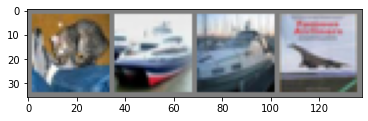

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像と正解ラベルの表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

次に、保存したモデルを読み込んでみましょう：

（注：ここでは本来、モデルの保存と再読み込みは必要ありません。ですが、その方法を紹介するために記載しています）



In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

そして、ニューラルネットワークが上記の入力を、どのように捉えたのか確認しましょう。


In [11]:
outputs = net(images)

出力は入力画像に対する10個のカテゴリの"エネルギー"（のようなもの）を表しています。

とあるカテゴリのエネルギーが高いほど、ネットワークはその画像がそのカテゴリに属すると考えます。

ですので、エネルギーが最も高いカテゴリを取得しましょう：


In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


かなり良い結果です。

では、ネットワークがデータセット全体に対しどの程度の性能になっているか確認しましょう。


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


チャンスレベル（10クラスの中からランダムにクラスを選ぶ場合）の10%より良い結果です。

ネットワークが何らかを学習しているようです。

ではうまく分類できたクラス、できなかったクラスはそれぞれ何だったのでしょうか：


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 42 %
Accuracy of   car : 73 %
Accuracy of  bird : 38 %
Accuracy of   cat : 43 %
Accuracy of  deer : 38 %
Accuracy of   dog : 45 %
Accuracy of  frog : 74 %
Accuracy of horse : 63 %
Accuracy of  ship : 73 %
Accuracy of truck : 65 %


さて、次はどうしましょうか。

ところで、どのようにして、ニューラルネットワークをGPUで実行するのでしょうか？

[6] GPU上で学習する方法
===============

テンソルをGPUに転送するのと同じように、ニューラルネットワークをGPUに転送します。

CUDAが利用可能な環境でしたら、自分のマシンを1つ目のcudaデバイスとして定義してみましょう。



In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GPU搭載のCUDA環境を前提としており、その場合はcuda:0と出力されるはずです

print(device)

cuda:0


このチュートリアルの残りの部分は、``device``がCUDAデバイスであることを前提としています。

※日本語訳注：

仮に、google Colaboratoryで本チュートリアルを実行し、``print(device)``の結果が``cpu``だった場合は、GPU環境に切り替えます。

画面上段のツールバーから「編集」→「ノートブックの設定」→「ハードウェアアクセラレータ」の項目でGPUを選択することで、GPUを利用することができます。

以下のメソッドは、ネットワーク内の全モジュールを再帰的に調べ、全モジュールのパラメータとバッファをCUDAテンソルに変換します:

In [16]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

ループ内では、以下のように、毎ステップ、入力データと正解ラベルもGPUに送る必要があることも忘れないでください：

In [17]:
inputs, labels = data[0].to(device), data[1].to(device)

ですが、今回はCPUで実行した際と比較して、大幅な高速化にはならないかと思います。
その理由は、今回のネットワークのサイズが小さいからです。

<br>

（日本語訳注：以下にGPUで実行するプログラムを記載しています。

またネットワークサイズが小さいと、ネットワーク内の順伝搬、逆伝搬、パラメータ更新の時間はあまり問題とならず、データをロードするCPU部分の処理時間の方が支配的になります。）


In [19]:
# 日本語訳注：GPU版で訓練を実行した場合

# optimizerを再定義（netがGPU上に移動したので）
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2):  # データセットを何巡繰り返すか

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 入力を取得します; 変数dataはリスト[inputs, labels]です
        # inputs, labels = data  # cpuの場合をコメントアウト
        inputs, labels = data[0].to(device), data[1].to(device)

        # 勾配を0に初期化
        optimizer.zero_grad()

        # 順伝搬、逆伝搬、パラメータ更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計情報を出力
        running_loss += loss.item()
        if i % 2000 == 1999:    #  2000ミニバッチごとに出力
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.204
[1,  4000] loss: 1.208
[1,  6000] loss: 1.207
[1,  8000] loss: 1.195
[1, 10000] loss: 1.174
[1, 12000] loss: 1.179
[2,  2000] loss: 1.104
[2,  4000] loss: 1.110
[2,  6000] loss: 1.111
[2,  8000] loss: 1.093
[2, 10000] loss: 1.108
[2, 12000] loss: 1.116
Finished Training


**演習：**ネットワークの幅を広げてみてください

（ただし、最初のnn.Conv2dの2つ目の引数と、2番目のnn.Conv2dの1つ目の引数は同じ数である必要があります）。

幅を広げると、CPU版とGPU版を比較した際に、どのような高速化が得られるか試してください。

**本チュートリアルで達成した目標：**

- PyTorchのTensorライブラリとニューラルネットワークをしっかりと理解する
- 画像分類の小さなニューラルネットワークを訓練させる


複数のGPUで学習する
-------------------------
すべてのGPUを使用して、さらに高速化を実現したい場合は、以下の内容も確認してください。

[データ並列処理のチュートリアル](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)





次に推奨する学習項目一覧
-------------------

-  [ビデオゲームをプレイするニューラルネットを訓練](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
-  [最先端のResNetネットワークをimagenetで訓練](https://github.com/pytorch/examples/tree/master/imagenet)
-   [人の顔画像を生成するネットワークをGAN（Generative Adversarial Networks）で訓練](https://github.com/pytorch/examples/tree/master/dcgan)
-  [Recurrent LSTM networksを用いた単語レベルの言語モデルを訓練](https://github.com/pytorch/examples/tree/master/word_language_model)
-  [その他のサンプル例](https://github.com/pytorch/examples)
-  [さらなるチュートリアルの一覧](https://github.com/pytorch/tutorials)
-  [フォーラムでPyTorchについて議論する](https://discuss.pytorch.org/)
-  [Slackで他のユーザーとチャットする](https://pytorch.slack.com/messages/beginner/)

